<a href="https://colab.research.google.com/github/NagaShivaChaitanya7/Bank-Marketing-Campaign-Term-Deposit-Prediction/blob/main/BankMarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


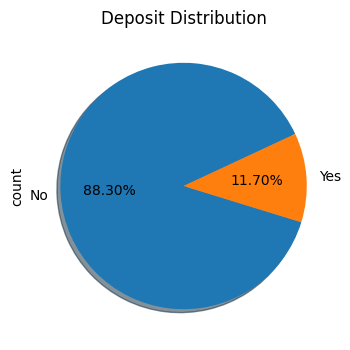

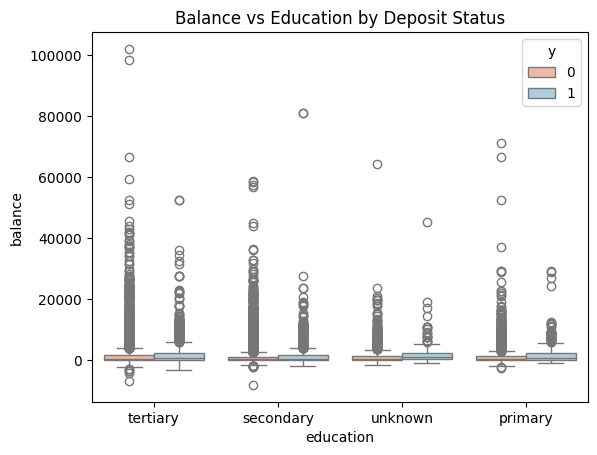

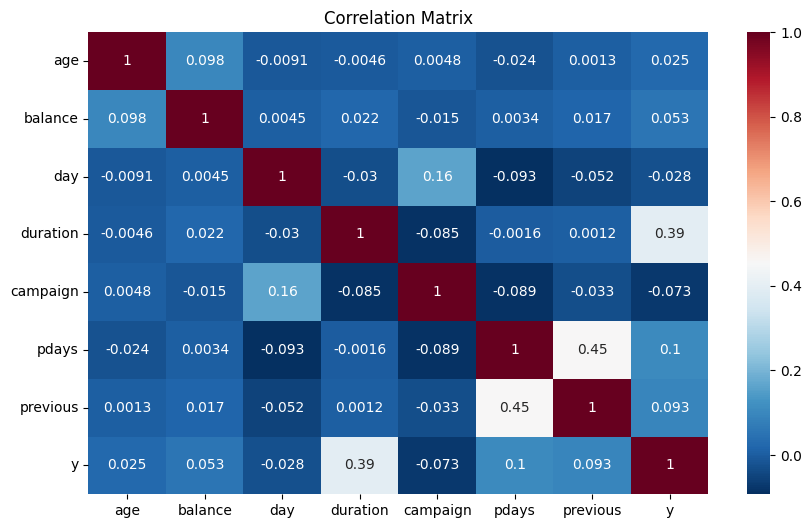

In [2]:
# =========================
# Part 1 — Load & Inspect Data
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("bank-full (1).csv", sep=";")
print("Data Shape:", df.shape)
print(df.head())

# Encode target
df['y'] = df['y'].map({'yes':1, 'no':0})

# ⚠️ Drop 'duration' for realistic performance (optional)
# df = df.drop(columns=['duration'])

# EDA
plt.figure(figsize=(6,4))
df['y'].value_counts().plot.pie(autopct='%1.2f%%', labels=['No','Yes'], shadow=True, startangle=25)
plt.title("Deposit Distribution")
plt.show()

sns.boxplot(x="education", y="balance", hue="y", data=df, palette="RdBu")
plt.title("Balance vs Education by Deposit Status")
plt.show()

corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="RdBu_r")
plt.title("Correlation Matrix")
plt.show()


In [3]:
# =========================
# Part 2 — Preprocess & Balance
# =========================

# Split features/labels
X = df.drop(columns=['y'])
y = df['y']

# Identify numeric & categorical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Preprocessing (one-hot encode + scale)
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_processed = preprocess.fit_transform(X)

# Balance with SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_processed, y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (63875, 51)  Test shape: (15969, 51)


In [4]:
# =========================
# Part 3 — Baseline Models
# =========================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Neural Net": MLPClassifier(max_iter=500),
    "Naive Bayes": GaussianNB()
}
if xgb_available:
    dict_classifiers["XGBoost"] = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", use_label_encoder=False,
        random_state=42
    )

print("\n=== Training baseline models ===")
for name, clf in dict_classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy={acc:.4f}")



=== Training baseline models ===
Logistic Regression: Accuracy=0.8446
Nearest Neighbors: Accuracy=0.9210
Linear SVM: Accuracy=0.9072
Gradient Boosting: Accuracy=0.9158
Decision Tree: Accuracy=0.9161
Random Forest: Accuracy=0.9552
Neural Net: Accuracy=0.9267
Naive Bayes: Accuracy=0.7496


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:55:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Accuracy=0.9370


In [5]:
# =========================
# Part 4 — Voting Ensemble
# =========================

from sklearn.ensemble import VotingClassifier

rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)

base_learners = [('rf', rf), ('gb', gb)]
if xgb_available:
    base_learners.append(('xgb', dict_classifiers["XGBoost"]))

ensemble = VotingClassifier(estimators=base_learners, voting='soft')

# Train ensemble
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
y_proba = ensemble.predict_proba(X_test)[:,1]

print("\nEnsemble Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ----------------------------
# Overfit Mode (demo only)
# ----------------------------
ensemble.fit(X_res, y_res)
y_pred_overfit = ensemble.predict(X_res)
print("\nOverfit Accuracy:", accuracy_score(y_res, y_pred_overfit))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:05:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Ensemble Accuracy: 0.9417621641931242
ROC-AUC: 0.9894494216987513
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      7985
           1       0.93      0.96      0.94      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969

Confusion Matrix:
 [[7412  573]
 [ 357 7627]]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:10:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Overfit Accuracy: 0.9602474825910525
